# CS6140 Final Project Proposal: Walkability Index
### Team Members: James Fan, James Florez, Dominic Cauteruccio, Sara Spasojevic


## Step 0: Notebook Prep


In [1]:
import pandas as pd
import numpy as np
from sklearn import *
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Set display options
pd.set_option("display.max_rows", 40)
pd.set_option("display.max_columns", 40)

# Set global random state
random_state = 1

## Step 1: Data Preprocessing and Analysis

#### Load Data

In [7]:
data_url = "https://edg.epa.gov/EPADataCommons/public/OA/EPA_SmartLocationDatabase_V3_Jan_2021_Final.csv"
raw_df = pd.read_csv(data_url, sep=",", header=0)
raw_df.head()



URLError: <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>

In [4]:
columns = ['Ac_Total', 'Ac_Water', 'Ac_Land', 'Ac_Unpr', 'TotPop', 'CountHU', 'HH', 'P_WrkAge', 'Pct_AO0',\
           'Pct_AO1', 'Pct_AO2p', 'Workers', 'R_LowWageWk', 'R_MedWageWk', \
           'R_HiWageWk', 'TotEmp', 'E5_Ret', 'E5_Off', 'E5_Ind', 'E5_Svc', 'E5_Ent', \
           'E_LowWageWk', 'E_MedWageWk', 'E_HiWageWk', \
           'D1A', 'D1B', 'D1C', 'D1D', 'D2C_TRPMX2', 'D2R_WRKEMP', 'D5AR', \
           'D5AE', 'D5BR', 'D5BE', 'NatWalkInd',]

df = raw_df[columns]
df.shape

#### Describe Data

In [5]:
# get column types
df.dtypes

Ac_Total       float64
Ac_Water       float64
Ac_Land        float64
TotPop           int64
P_WrkAge       float64
AutoOwn0         int64
AutoOwn1         int64
AutoOwn2p        int64
Workers          int64
R_LowWageWk      int64
R_MedWageWk      int64
R_HiWageWk       int64
TotEmp           int64
E_LowWageWk      int64
E_MedWageWk      int64
E_HiWageWk       int64
D1A            float64
D1B            float64
D1C            float64
D1D            float64
D2C_TRPMX2     float64
D2R_WRKEMP     float64
D5AR             int64
D5AE             int64
D5BR             int64
D5BE             int64
dtype: object

In [6]:
# describe numeric variables
df.describe()

,Ac_Total,Ac_Water,Ac_Land,TotPop,P_WrkAge,AutoOwn0,AutoOwn1,AutoOwn2p,Workers,R_LowWageWk,R_MedWageWk,R_HiWageWk,TotEmp,E_LowWageWk,E_MedWageWk,E_HiWageWk,D1A,D1B,D1C,D1D,D2C_TRPMX2,D2R_WRKEMP,D5AR,D5AE,D5BR,D5BE
count,2.207400e+05,2.207400e+05,2.207400e+05,220740.000000,220740.00000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,220469.000000,220740.000000,220740.000000,220740.000000,220740.000000,220740.000000,2.207400e+05,220740.000000,2.207400e+05,2.207400e+05
mean,1.103567e+04,7.807248e+02,1.025494e+04,1479.863804,0.59474,48.126511,181.123960,318.612186,637.816753,146.015815,210.235820,281.565117,639.106487,146.436255,211.019806,281.650426,4.530262,10.428739,3.773612,8.298313,0.491936,0.425024,1.030618e+05,88536.521695,4.413897e+04,1.520207e+02
std,1.588982e+05,2.683978e+04,1.488759e+05,987.862242,0.10610,83.669015,146.710107,248.403557,420.866297,90.312972,135.076957,235.370220,2021.360339,357.650538,550.314594,1273.883797,13.881912,29.129998,46.392440,50.474119,0.234264,0.306272,1.531004e+05,130263.329763,3.854568e+05,2.038590e+05
min,1.096136e+00,0.000000e+00,0.000000e+00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-9.999900e+04,-9.999900e+04
25%,1.231824e+02,0.000000e+00,1.200676e+02,889.000000,0.54400,5.000000,90.000000,169.000000,384.000000,91.000000,127.000000,136.000000,69.000000,19.000000,25.000000,17.000000,0.300543,0.714507,0.075862,0.531225,0.326433,0.153326,9.260000e+03,9150.000000,-9.999900e+04,-9.999900e+04
50%,3.394946e+02,0.000000e+00,3.229443e+02,1265.000000,0.59500,21.000000,146.000000,269.000000,550.000000,128.000000,183.000000,226.000000,200.000000,54.000000,72.000000,59.000000,1.845611,4.320753,0.533630,3.140893,0.509930,0.389110,4.273400e+04,38964.000000,-9.999900e+04,-9.999900e+04
75%,2.325991e+03,1.973606e+01,2.141221e+03,1816.000000,0.64800,57.000000,231.000000,409.000000,792.000000,181.000000,263.000000,362.000000,548.000000,145.000000,198.000000,181.000000,4.163989,10.136846,2.157909,6.834936,0.685096,0.684399,1.251635e+05,105586.000000,4.775125e+04,3.174650e+04
max,4.055649e+07,5.455459e+06,3.914039e+07,55407.000000,1.00000,3834.000000,15285.000000,13158.000000,19255.000000,3639.000000,5014.000000,10683.000000,266101.000000,38083.000000,49946.000000,204309.000000,1481.257220,3133.578265,14032.760640,14111.660620,0.991059,1.000000,1.220602e+06,964355.000000,6.963967e+06,2.697797e+06


In [7]:
# show null values
print(df.isnull().sum().sort_values(ascending=False))

Ac_Total         0
Ac_Water         0
Ac_Land          0
TotPop           0
P_WrkAge         0
AutoOwn0         0
AutoOwn1         0
AutoOwn2p        0
Workers          0
R_LowWageWk      0
R_MedWageWk      0
R_HiWageWk       0
TotEmp           0
E_LowWageWk      0
E_MedWageWk      0
E_HiWageWk       0
D1A            271
D1B              0
D1C              0
D1D              0
D2C_TRPMX2       0
D2R_WRKEMP       0
D5AR             0
D5AE             0
D5BR             0
D5BE             0
dtype: int64


In [8]:
# Drop household NaN samples
df = df.dropna(subset=['CountHU'], axis=0)
df = df.dropna(subset=['HH'], axis=0)

# fill the leftover null variables with median
df = df.fillna(df.median())

df.shape


# EDA - Univariate Analysis

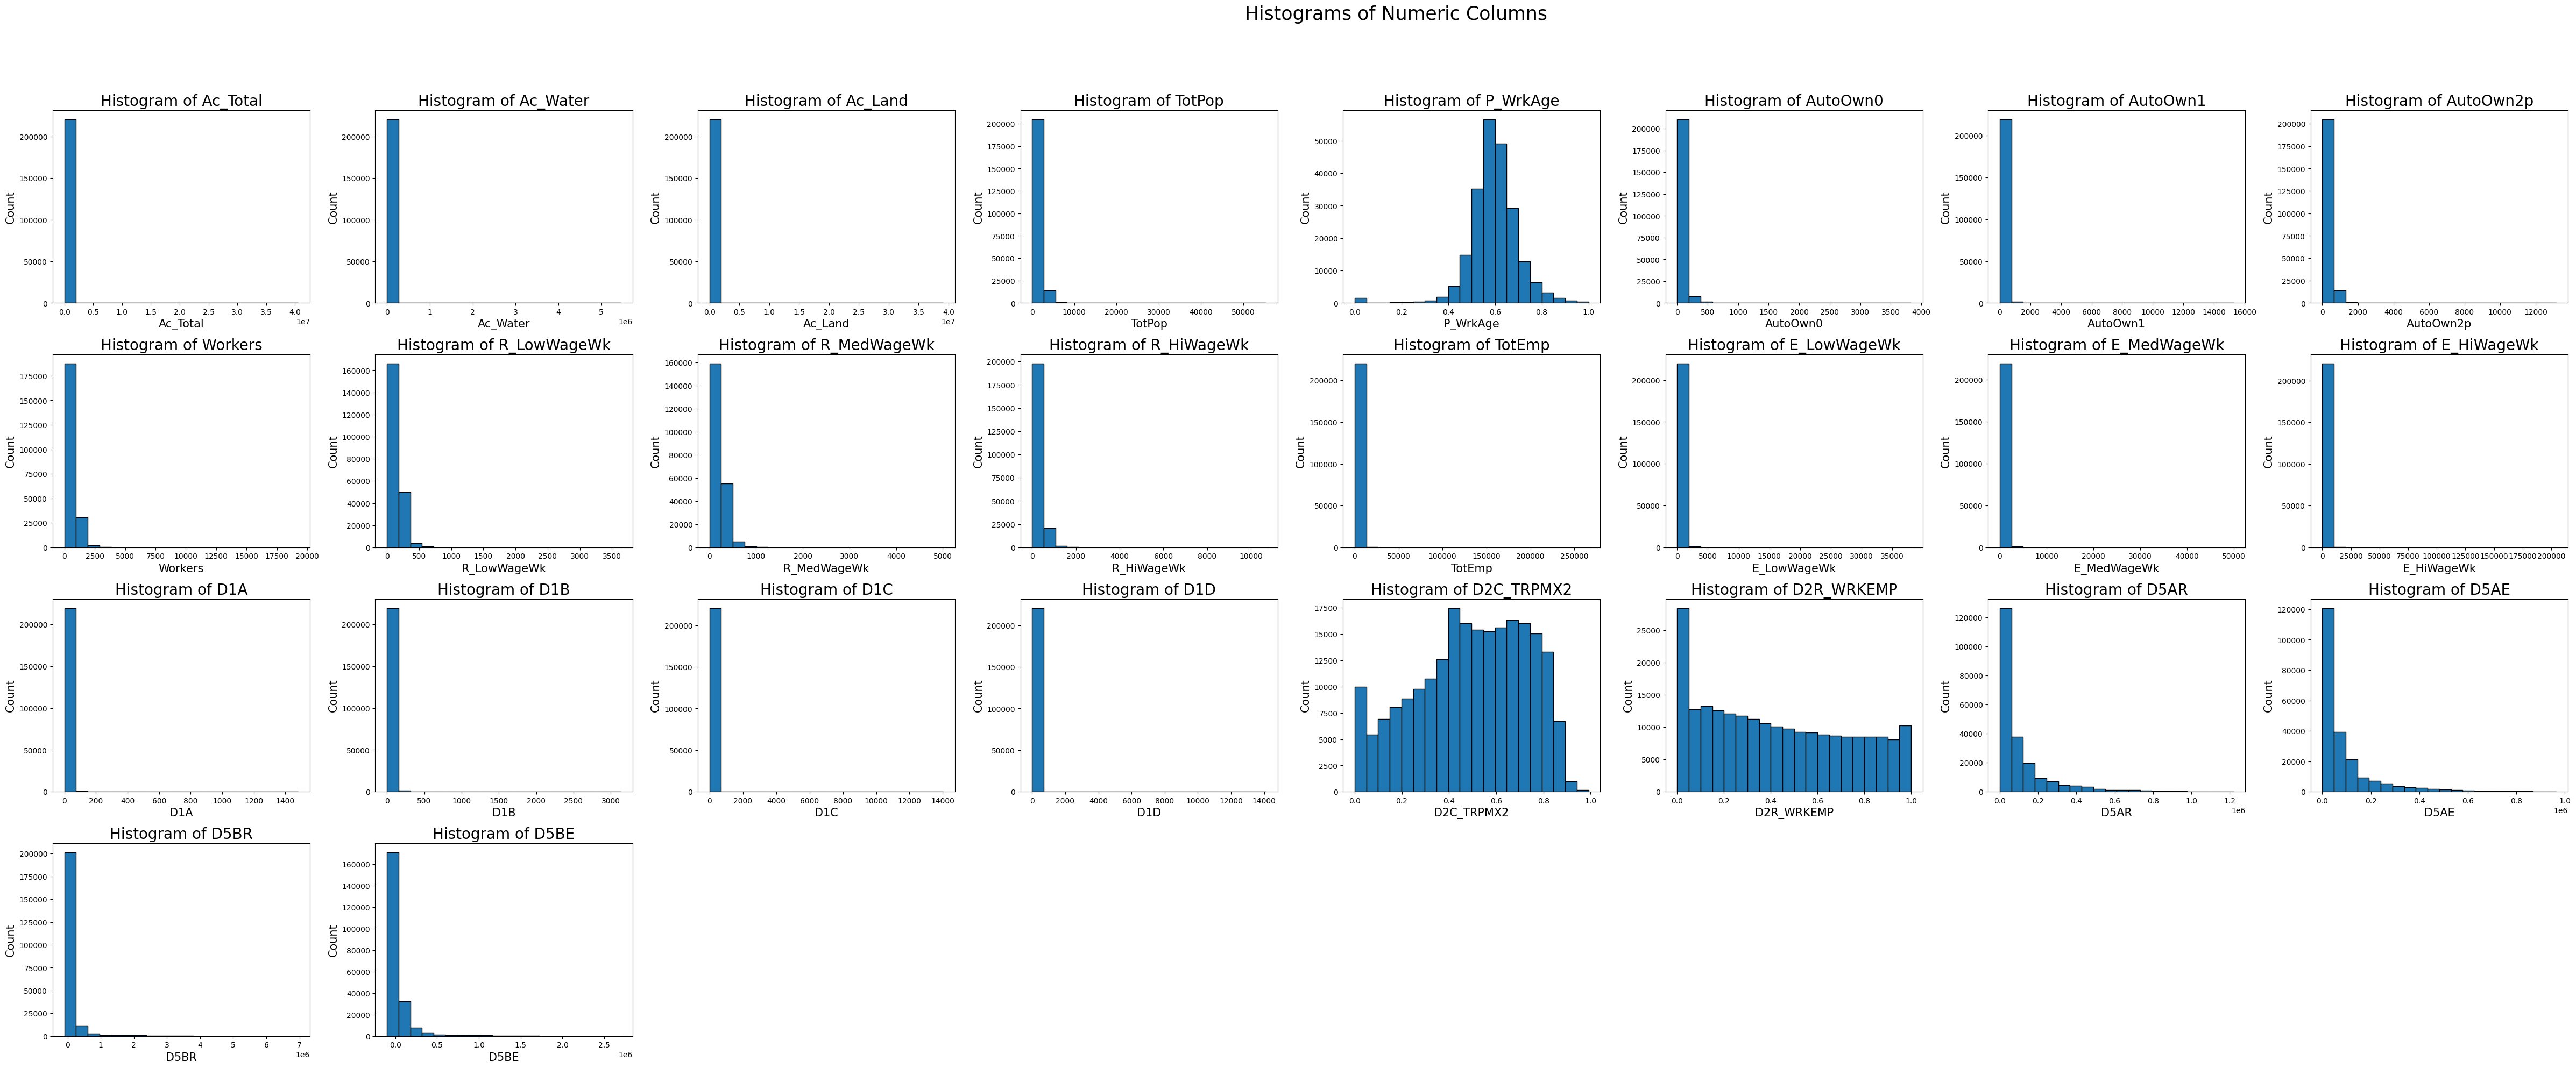

In [9]:
# Univariate Analysis

import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms for selected numeric columns with larger individual plots
plt.figure(figsize=(40, 30))
for i, column in enumerate(df.columns):
    plt.subplot(8, 8, i + 1)
    df[column].hist(bins=20, edgecolor='black', linewidth=1.0, grid=False)
    plt.title(f'Histogram of {column}', fontsize=20)
    plt.xlabel(column, fontsize=15)
    plt.ylabel('Count', fontsize=15)

plt.tight_layout(rect=(0, 0, 1.2, 1.2))
plt.suptitle('Histograms of Numeric Columns', x=0.65, y=1.25, fontsize=25)
plt.show()


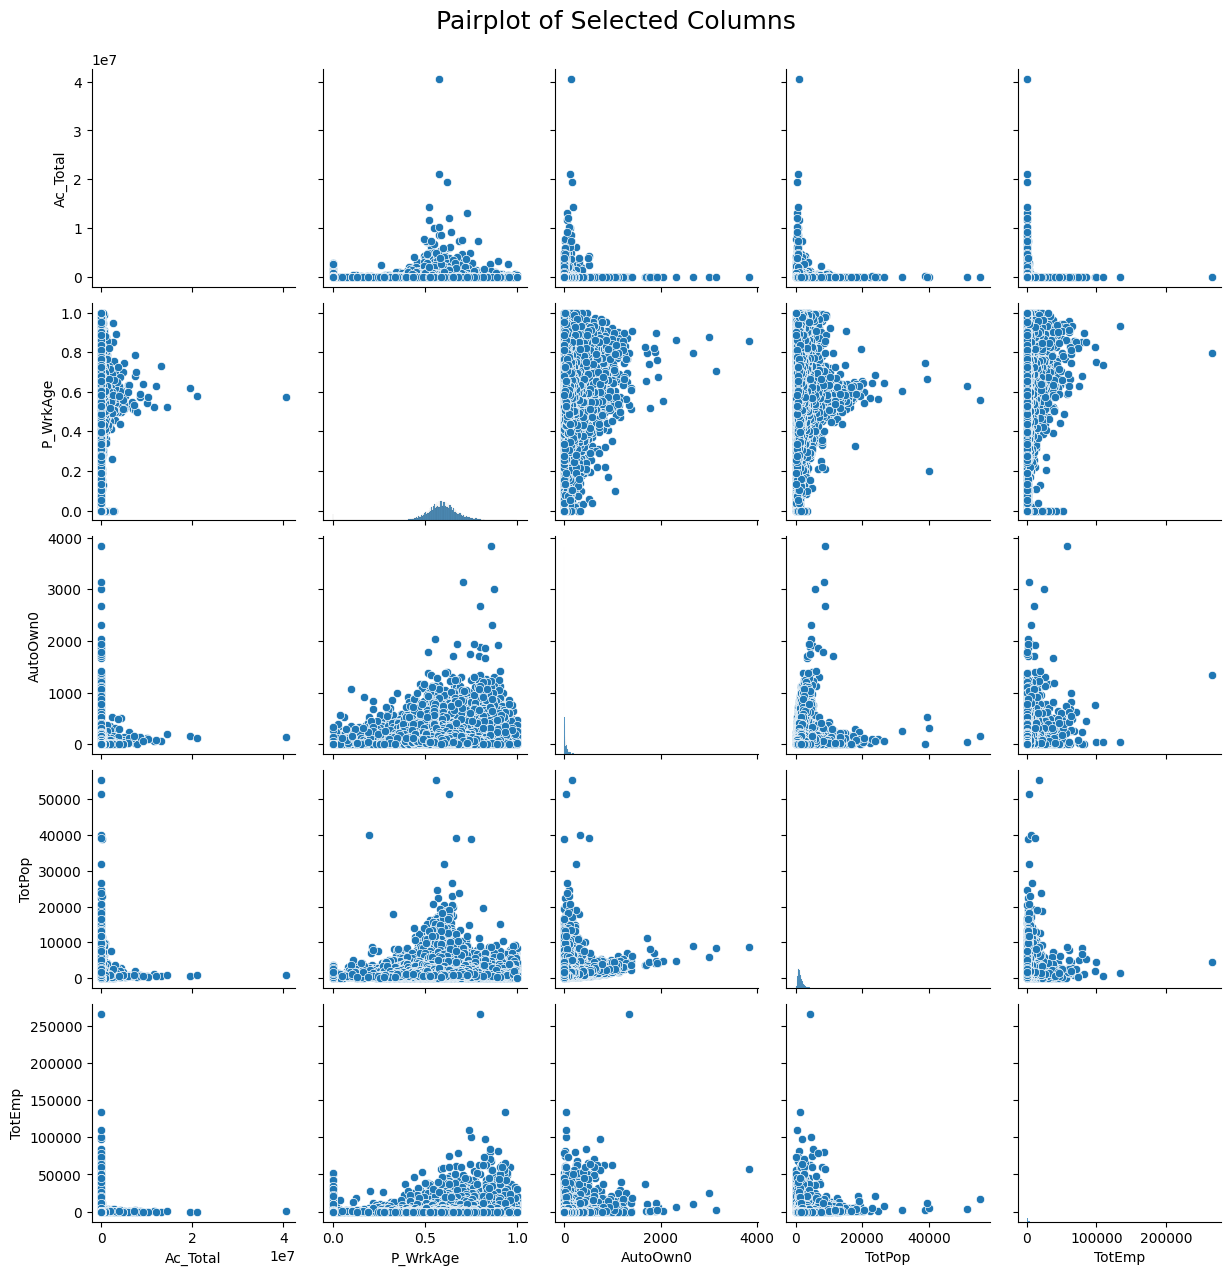

In [10]:
# Bivariate Analysis
# Calculate correlation matrix
correlation_matrix = df.corr()

# Plot pairplot for selected columns
sns.pairplot(df[['Ac_Total', 'P_WrkAge', 'AutoOwn0', 'TotPop', 'TotEmp']])
plt.suptitle('Pairplot of Selected Columns', y=1.02, fontsize=18)
plt.show()

## Step 2: Model Creation

#### Split and Standardize the Dataset

In [11]:
# Split data into X and Y
X = df
y = raw_df["NatWalkInd"]

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=random_state)

# Standardize X
scaler = preprocessing.StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

#### Define Hyperparameters and Initialize Models

In [12]:
# Linear Regression
linear = linear_model.LinearRegression()

# Ridge Regression
ridge_alpha = 1.0
ridge = linear_model.Ridge(alpha=ridge_alpha)

# Random Forest
rf_estimators = 10
random_forest = ensemble.RandomForestRegressor(n_estimators=rf_estimators, random_state=random_state)

# Support Vector Machine (SVM)
svm_kernel = "rbf"
svm_c = 3
svm_max_iter = 2000
svm_model = svm.SVR(kernel=svm_kernel, C=svm_c, max_iter=svm_max_iter)

# Multi-Layer Perceptron (MLP)
mlp_num_layers = 5
mlp_num_neurons = 5
mlp_alpha = 0.0001
mlp_learning_rate_init = 0.001
mlp_max_iter = 1000
mlp = neural_network.MLPRegressor(
    hidden_layer_sizes=(mlp_num_neurons, mlp_num_layers),
    alpha=mlp_alpha,
    learning_rate_init=mlp_learning_rate_init,
    max_iter=mlp_max_iter,
    random_state=random_state)

## Step 3: Model Training and Evaluation

In [13]:
# Define a function to train and evaluate a regression model

def model_train_and_eval(model, X_train, X_test, y_train, y_test, model_name):
  # Given a regression model and data, this trains the model, plots the coefficients, and evaluates the performance.

  # Train the model with training data
  model.fit(X_train, y_train)

  # Make predicitions on test data
  y_pred = model.predict(X_test)

  # Plot the weights of the model
  if (model_name in ["Linear", "Ridge"]):
    plt.plot(X.columns, model.coef_)
    plt.title(f"Coefficients of {model_name} Regression Model")
    plt.xticks(rotation=90)
    plt.grid()
    plt.show()

  # Evaluate performance of the model
  mse = metrics.mean_squared_error(y_test, y_pred)
  r2 = metrics.r2_score(y_test, y_pred)
  print(f"Mean Squared Error: {mse}")
  print(f"R-squared: {r2}")

  return mse, r2


# Initialize variable to hold MSE and R^2 results
mse_list = []
r2_list = []

#### Linear Regression

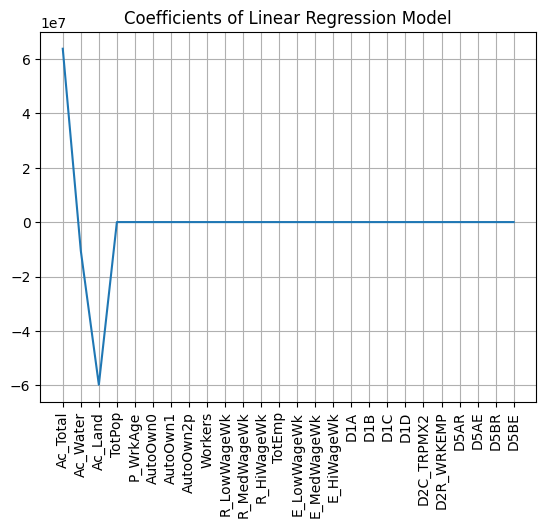

Mean Squared Error: 7.780483574149218
R-squared: 0.5945770424874679


In [14]:
linear_mse, linear_r2 = model_train_and_eval(linear, X_train_std, X_test_std, y_train, y_test, "Linear")
mse_list.append(linear_mse)
r2_list.append(linear_r2)

#### Ridge Regression

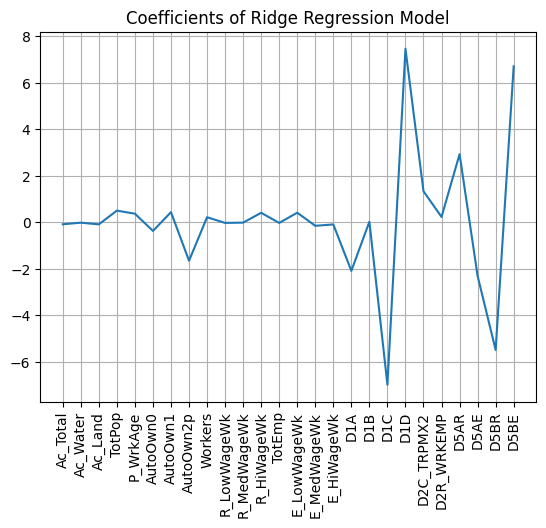

Mean Squared Error: 7.786628857599313
R-squared: 0.5942568260166861


In [15]:
ridge_mse, ridge_r2 = model_train_and_eval(ridge, X_train_std, X_test_std, y_train, y_test, "Ridge")
mse_list.append(ridge_mse)
r2_list.append(ridge_r2)

#### Random Forest

In [16]:
rf_mse, rf_r2 = model_train_and_eval(random_forest, X_train_std, X_test_std, y_train, y_test, "Random Forest")
mse_list.append(rf_mse)
r2_list.append(rf_r2)

Mean Squared Error: 1.6281356271008982
R-squared: 0.9151616278242775


#### Support Vector Machine

In [17]:
svm_mse, svm_r2 = model_train_and_eval(svm_model, X_train_std, X_test_std, y_train, y_test, "SVM")
mse_list.append(svm_mse)
r2_list.append(svm_r2)

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=2000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Mean Squared Error: 5.5555411105566685
R-squared: 0.7105136350254898


#### Multi-Layer Perceptron

In [18]:
mlp_mse, mlp_r2 = model_train_and_eval(mlp, X_train_std, X_test_std, y_train, y_test, "MLP")
mse_list.append(mlp_mse)
r2_list.append(mlp_r2)

Mean Squared Error: 1.74629193959253
R-squared: 0.9090047763634901


#### Plot Performance of Different Models

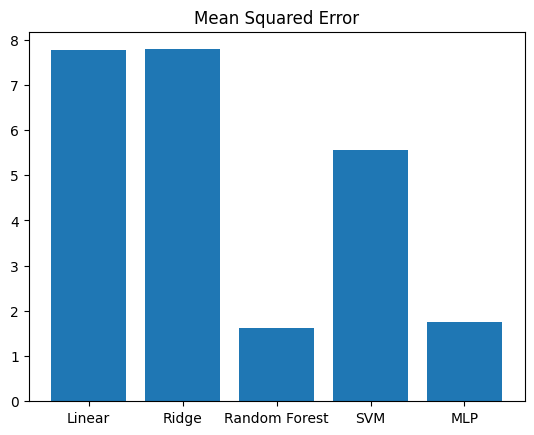

In [22]:
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP"], mse_list)
plt.title("Mean Squared Error")
plt.show()

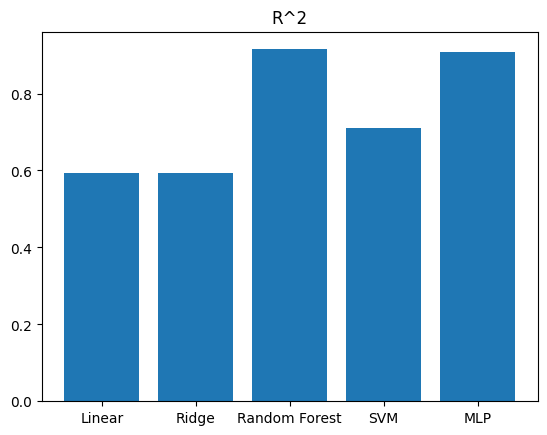

In [23]:
plt.bar(["Linear", "Ridge", "Random Forest", "SVM", "MLP"], r2_list)
plt.title("R^2")
plt.show()

## Step X?: Principal Component Analysis

#### Compare the performance of the strongest model with and without PCA

In [ ]:
# PCA on the training set
pca = decomposition.PCA()  # Specify the number of components
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

# Scree plot
explained_variance_ratio = pca.explained_variance_ratio_
num_components = len(explained_variance_ratio)
plt.figure(figsize=(8, 5))
plt.bar(np.arange(num_components) + 1, explained_variance_ratio, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()